In [2]:
import interfere
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps

SEED = 11
NOTEBOOK_RNG = np.random.default_rng(SEED)

In [3]:
def uniform_init_cond(min_x, max_x, dim, reps, rng=NOTEBOOK_RNG):
    """Generates initial conditions for dynamic models."""
    return [
        (max_x - min_x) * rng.random(dim) + min_x for i in range(reps)
    ]

# Stochasticity: Invervention Response v.s. Forecasting

We have previously shown that stochasticity is beneficial when trying to
understand how a system will respond to an intervention. However, we have yet to
explore if the same property holds for forecasting in general.

The experiments in this notebook are a first look that attempts to shed light on
the effect of stochasticity on traditional forecasting.

### Parameterize a 10 Dimensional Generalized Lotka-Voltera Model

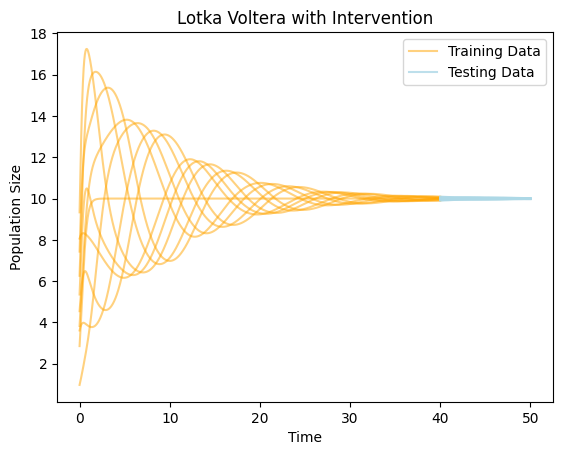

In [24]:
dim = 10
reps = 10

params = dict(
    model_type=interfere.dynamics.LotkaVolteraSDE,
    model_params={
        "growth_rates": 5 * NOTEBOOK_RNG.random(dim),
        "capacities": 20 * np.ones(dim),
        # A cycle and isolated node
        "interaction_mat": np.array([
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "sigma": 0.0,
        "measurement_noise_std": 0.0 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 5.0},
    initial_conds=uniform_init_cond(0, 10, dim, reps),
    start_time=0, end_time=50, dt=0.01,
    rng = np.random.default_rng(SEED)
)


Xs, X_dos, t = interfere.generate_counterfactual_forecasts(**params)
sample_X, sample_X_do = Xs[2], X_dos[2]
n_do = sample_X_do.shape[0]

X_train = sample_X[:-n_do]
t_train = t[:-n_do]
X_test = sample_X[-n_do:]
t_test = t[-n_do:]


plt.plot(t_train, X_train, alpha=0.5, c="orange")
plt.plot(t_test, X_test, alpha=0.8, c="lightblue")
plt.plot(t[0], sample_X[0, 0], alpha=0.5, c="orange", label="Training Data")
plt.plot(t[-1], sample_X[-1, 0], alpha=0.8, c="lightblue", label="Testing Data")
plt.xlabel("Time")
plt.ylabel("Population Size")
plt.title("Lotka Voltera with Intervention")
plt.legend()
plt.show()



In [25]:
def sindy_forecast(
    sindy_params, X_historic, historic_times, forecast_times, max_sim_val=1e3):

    # Fit the sindy model.
    sindy = ps.SINDy()
    sindy.set_params(**sindy_params)
    sindy.fit(X_historic, historic_times)

    # Stop criteria for SINDy integrator in case sim diverges.
    too_big = lambda t, y: np.all(np.abs(y) < max_sim_val)
    too_big.terminal = True
    
    # Run simulation.
    X_forecast = sindy.simulate(
        X_historic[-1, :],
        forecast_times,
        integrator_kws={"events": too_big}
    )

    return X_forecast


In [26]:
def repeat_last_row(A: np.ndarray, desired_nrows):
    last_row = A[-1, :]
    n0, _ = A.shape
    A_extend = np.vstack(
        [A] + [last_row for _ in range(desired_nrows - n0)]
    )
    return A_extend

In [28]:

best_params = {
    "differentiation_method": ps.SINDyDerivative(kind='spectral'),
    'differentiation_method__kwargs': {'kind': 'finite_difference', 'k': 1},'optimizer__alpha': 0.0,
    'optimizer__threshold': 0.05
}

X_pred = sindy_forecast(best_params, X_train, t_train, t_test)
X_pred_extend = repeat_last_row(X_pred, len(t_test))

plt.plot(t_test, X_test, alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Population Size")
plt.plot(t_test, X_pred_extend, c="r", label="Prediction")
plt.show()

KeyboardInterrupt: 